Let variance of Gaussian distribution be 

\begin{align}
\sigma^{2} (1+a) & \quad \text{with prob p} \\
\sigma^{2} (1-a \frac{p}{1-p}) & \quad \text{with prob 1-p} \\
\end{align}

Then standard deviation of the distribution

\begin{align}
\sigma \sqrt{1+a} & \quad \text{with prob p} \\
\sigma \sqrt{1-a \frac{p}{1-p}} & \quad \text{with prob 1-p} \\
\end{align}

Variance calcualted from moment generating function is still $\sigma^2$!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
from statsmodels.sandbox.distributions.extras import pdf_moments
from scipy.integrate import simps
import scipy.interpolate as interpolate
import random
import matplotlib.ticker as ticker
def magnitude(x):
    import math
    return int(math.log10(x))
state = np.random.RandomState(999)
np.random.seed(seed=999)

scale1: 2.0
scale2: 0.7687061147858074
kurtosis: 6.681818181818182
Min value of pdf_mixedg is above zero? True


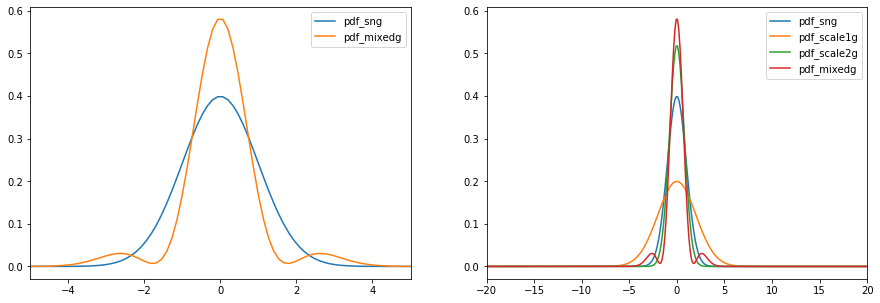

In [2]:
#random.seed(1)
# Choices
p = 0.12
a = 3.0

# Other variables
bins=300
sigma = 1
b = -a * (p / (1-p))
x, dx = np.linspace(-20, 20, bins, retstep=True)
n_draws = 8000

# Parameters
kurtosis = 3*((1-np.power(a,2))*p-1) / (p-1)
scale1 = sigma * np.sqrt(1+a)
scale2 = sigma * np.sqrt(1+b)
print("scale1: {}".format(scale1))
print("scale2: {}".format(scale2))
print("kurtosis: {}".format(kurtosis))

# pdfs
sng = norm()
scale1g = norm(loc=0, scale=scale1)
scale2g = norm(loc=0, scale=scale2)
mixedg = pdf_moments([0, sigma, 0, kurtosis])

# Into frame
df = pd.DataFrame()
df['pdf_sng'] = sng.pdf(x)
df['pdf_scale1g'] = scale1g.pdf(x)
df['pdf_scale2g'] = scale2g.pdf(x)
df['pdf_mixedg'] = mixedg(x)
df.index = x

print("Min value of {} is above zero? {}".format('pdf_mixedg',np.min(df['pdf_mixedg']) > 0))

# Plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
_ = df[['pdf_sng','pdf_mixedg']].plot(ax=ax)
ax.set_xlim(-5,5)
ax = fig.add_subplot(122)
_ = df.plot(ax=ax)

Area under sng: 100.00000%
Area under pdf_mixedg: 100.00000%


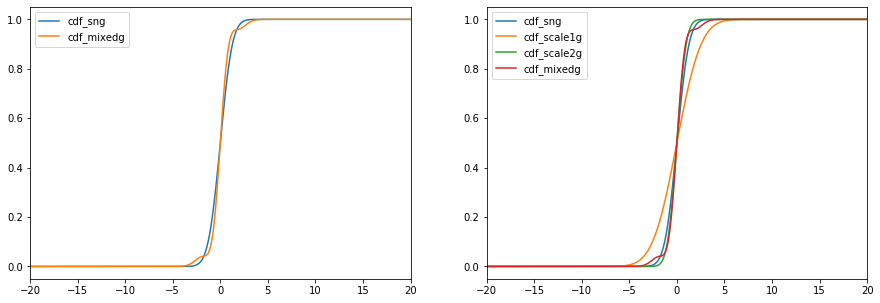

In [3]:
# Approximate cdf of mixed gaussian
myvals = np.empty(bins)
for i in range(bins):
    if i == 0:
        area = df.iloc[i, df.columns.get_level_values(0) == 'pdf_mixedg']
    else:
        area = simps(df.iloc[:i+1, df.columns.get_level_values(0) == 'pdf_mixedg'].iloc[:,0], dx=dx)
    myvals[i] = area
    
# cdfs into frame
df['cdf_sng'] = sng.cdf(x)
df['cdf_scale1g'] = scale1g.cdf(x)
df['cdf_scale2g'] = scale2g.cdf(x)
df['cdf_mixedg'] = myvals

print("Area under {}: {:.5%}".format("sng",simps(df['pdf_sng'], dx=dx)))
print("Area under {}: {:.5%}".format("pdf_mixedg",simps(df['pdf_mixedg'], dx=dx)))

# Plot
fig = plt.figure(figsize=(15,5))
ax= fig.add_subplot(121)
_ = df[['cdf_sng','cdf_mixedg']].plot(ax=ax)
ax= fig.add_subplot(122)
_ = df[['cdf_sng','cdf_scale1g','cdf_scale2g','cdf_mixedg']].plot(ax=ax)

In [4]:
# Draws samples
# https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
random.seed(3)
inv_cdf = interpolate.interp1d(df['cdf_mixedg'], x)
df_draws = pd.DataFrame(data = sng.rvs(size=n_draws), columns=["sng"])
df_draws['scale1g'] = scale1g.rvs(size=n_draws, random_state = state)
df_draws['scale2g'] = scale2g.rvs(size=n_draws, random_state = state)
df_draws['mixedg'] = inv_cdf(np.random.rand(n_draws))

max abs value if sng is 3.5076016351147734
max abs value if mixedg is 5.086901452160438
Sample std of sng is 1.0
Sample std of mixedg is 1.0
Interquartile range of sng is 1.33 (-0.66, 0.66)
Interquartile range of mixedg is 0.94 (-0.49, 0.45)
--------------------------------------------------
Index of 5-sigma event: 4139
5-sigma event pobability in standard normal distribution: 0.00005733%, i.e. 0.57 times out of million
In our fat-tailed distribution, corresponding probability is 0.00471976%, i.e. 47.20 times out of million
Difference is 2 orders of magnitude
--------------------------------------------------


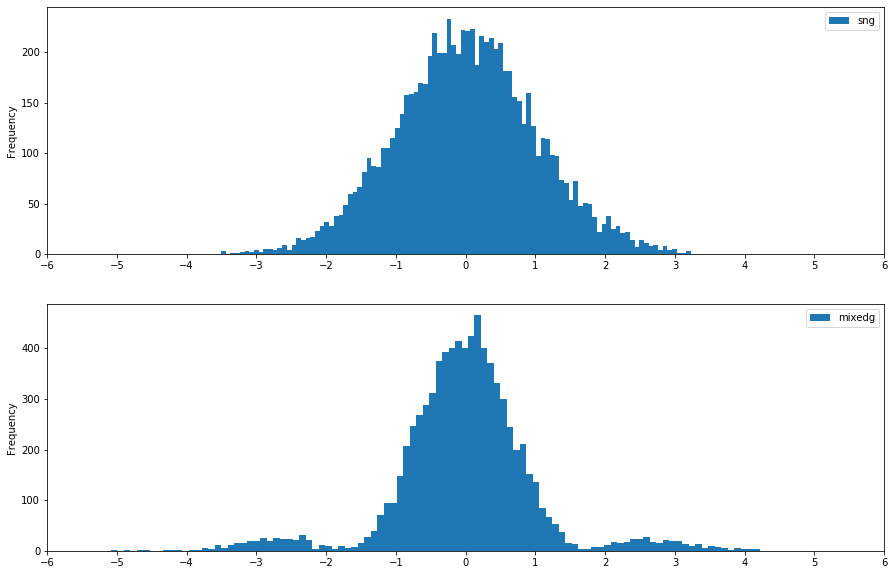

In [5]:
# Plots histogram of drawn values 
xlims = (-6,6)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
_ = df_draws[['sng']].plot(kind='hist', bins=100, ax=ax)
ax.xaxis.set_major_locator(ticker.FixedLocator((np.arange(xlims[0],xlims[1]+1,1))))
ax.set_xlim(xlims)
ax = fig.add_subplot(212)
_ = df_draws[['mixedg']].plot(kind='hist', bins=100, ax=ax)
ax.xaxis.set_major_locator(ticker.FixedLocator((np.arange(xlims[0],xlims[1]+1,1))))
ax.set_xlim(xlims)

print("max abs value if {} is {}".format("sng",np.max(np.abs(df_draws['sng']))))
print("max abs value if {} is {}".format("mixedg",np.max(np.abs(df_draws['mixedg']))))

print("Sample std of {} is {:.1f}".format("sng", np.std(df_draws['sng'])))
print("Sample std of {} is {:.1f}".format("mixedg", np.std(df_draws['mixedg'])))
print("Interquartile range of {} is {:.2f} ({:.2f}, {:.2f})".format("sng", scipy.stats.iqr(df_draws['sng']), np.quantile(df_draws['sng'],q=0.25), np.quantile(df_draws['sng'],q=0.75)))
print("Interquartile range of {} is {:.2f} ({:.2f}, {:.2f})".format("mixedg", scipy.stats.iqr(df_draws['mixedg']), np.quantile(df_draws['mixedg'],q=0.25), np.quantile(df_draws['mixedg'],q=0.75)))

print('-'*50)

n_sigma = 5
nsgima_sng = 2*norm.cdf(-5)
nsgima_mixedg = 2*simps(df.loc[df.index <= -5 , 'pdf_mixedg'], dx=dx)
print("Index of 5-sigma event: {}".format(df_draws[df_draws['mixedg'] < -5].index.values[0]))
print("{}-sigma event pobability in standard normal distribution: {:.8%}, i.e. {:.2f} times out of million".format(5, nsgima_sng, nsgima_sng*1000000))
print("In our fat-tailed distribution, corresponding probability is {:.8%}, i.e. {:.2f} times out of million".format(nsgima_mixedg, nsgima_mixedg*1000000))
print("Difference is {} orders of magnitude".format(np.abs(magnitude(nsgima_sng)) - np.abs(magnitude(nsgima_mixedg))))
print('-'*50)